In [1]:
import torch

from torch.utils.data import DataLoader
from torchvision import models
from torchvision import datasets
from torchvision import transforms

In [9]:
cfg = {}
cfg['data_dir'] = '/dgx/inoue/data'
cfg['batch_size'] = 1
cfg['epochs'] = 5
cfg['device'] = 'cuda:3'

<br>

## Define Teacher Network

In [10]:
pretrained_vgg = models.vgg19(pretrained=True)
teacher = pretrained_vgg.features[:36]
teacher = teacher.to(cfg['device'])
print('\n Full feature layers in vgg19 \n', pretrained_vgg.features)
print('\n Teacher network \n', teacher)


 Full feature layers in vgg19 
 Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): 

<br>

## Define Student Network

In [11]:
vgg = models.vgg19(pretrained=False)
student = vgg.features[:36]
student = student.to(cfg['device'])
print('\n Full feature layers in vgg19 \n', vgg.features)
print('\n Student network \n', student)


 Full feature layers in vgg19 
 Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): 

<br>

## Prepare Dataset

In [12]:
transform = transforms.Compose([transforms.Grayscale(3), # Match the mnist channel dim with vgg19 input
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                               ])

mnist = datasets.MNIST(root=cfg['data_dir'], 
                       train=True, 
                       download=True,
                       transform=transform)

train_loader = DataLoader(dataset=mnist,
                          batch_size=cfg['batch_size'],
                          shuffle=True)

In [13]:
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(student.parameters(), lr=0.0002, weight_decay=0.00001)

In [37]:
teacher.eval()

for epoch in range(cfg['epochs']):    
    for i, (img, digit) in enumerate(train_loader):
         
        if digit == 1:
            img = img.to(cfg['device'])
            with torch.no_grad():
                surrogate_label = teacher(img)
            optimizer.zero_grad()
            pred = student(img)
            loss = criterion(pred, surrogate_label)
            loss.backward()
            optimizer.step()

    print(f'epoch: {epoch}')

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4


In [38]:
teacher.eval()
student.eval()

losses = []
digits = []
for i, (img, digit) in enumerate(train_loader):
    with torch.no_grad():
        img = img.to(cfg['device'])
        surrogate_label = teacher(img)
        pred = student(img)
        loss = criterion(pred, surrogate_label)
        
        losses.append(loss.item())
        digits.append(digit)
    
    if i%1000 == 0:
        print(f'{i}/{len(train_loader)}')

0/60000
1000/60000
2000/60000
3000/60000
4000/60000
5000/60000
6000/60000
7000/60000
8000/60000
9000/60000
10000/60000
11000/60000
12000/60000
13000/60000
14000/60000
15000/60000
16000/60000
17000/60000
18000/60000
19000/60000
20000/60000
21000/60000
22000/60000
23000/60000
24000/60000
25000/60000
26000/60000
27000/60000
28000/60000
29000/60000
30000/60000
31000/60000
32000/60000
33000/60000
34000/60000
35000/60000
36000/60000
37000/60000
38000/60000
39000/60000
40000/60000
41000/60000
42000/60000
43000/60000
44000/60000
45000/60000
46000/60000
47000/60000
48000/60000
49000/60000
50000/60000
51000/60000
52000/60000
53000/60000
54000/60000
55000/60000
56000/60000
57000/60000
58000/60000
59000/60000


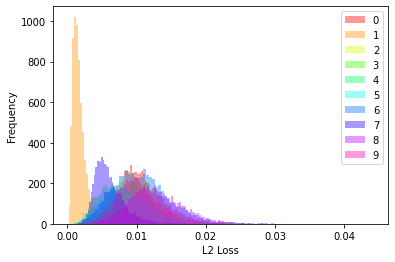

In [52]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

losses = np.array(losses)
digits = np.array(digits)

for i in range(10):
    color = cm.hsv(i/10)
    plt.hist(losses[digits==i], label=str(i), bins=100, color=color, alpha=0.4)

plt.legend()
plt.xlabel('L2 Loss')
plt.ylabel('Frequency')
plt.show()